In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly
plotly.tools.set_credentials_file(username='quoniammm', api_key='IF7kV6idFRdoo7LdgGRp')
import plotly.plotly as py
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import nltk

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [5]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


# 数据可视化

In [6]:
z = {'EAP': '爱伦坡', 'MWS': '玛丽雪莱', 'HPL': '洛夫克拉夫特'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='作家文选段落条目数'
    )]

layout = go.Layout(
    title='目标变量分布'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~quoniammm/0 or inside your plot.ly account where it is named 'basic-bar'


In [7]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~quoniammm/0 or inside your plot.ly account where it is named 'basic-bar'


In [8]:
eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values

(-0.5, 399.5, 199.5, -0.5)

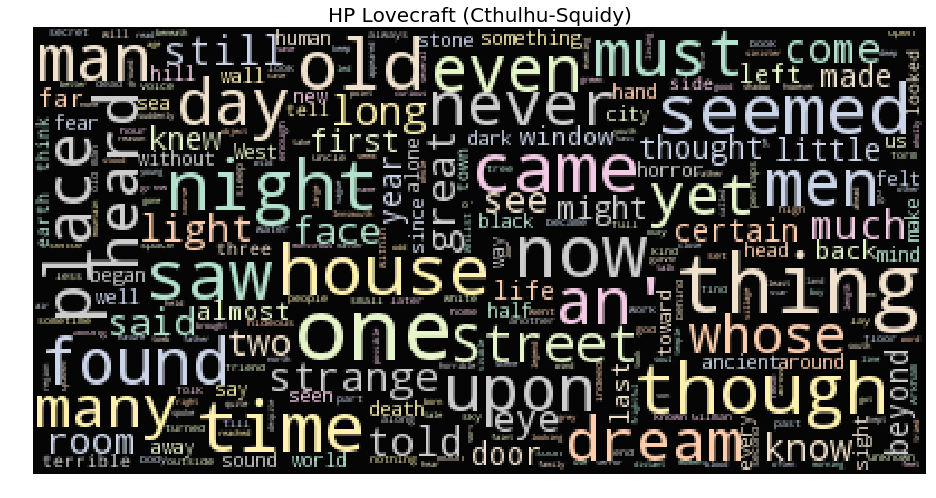

In [9]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

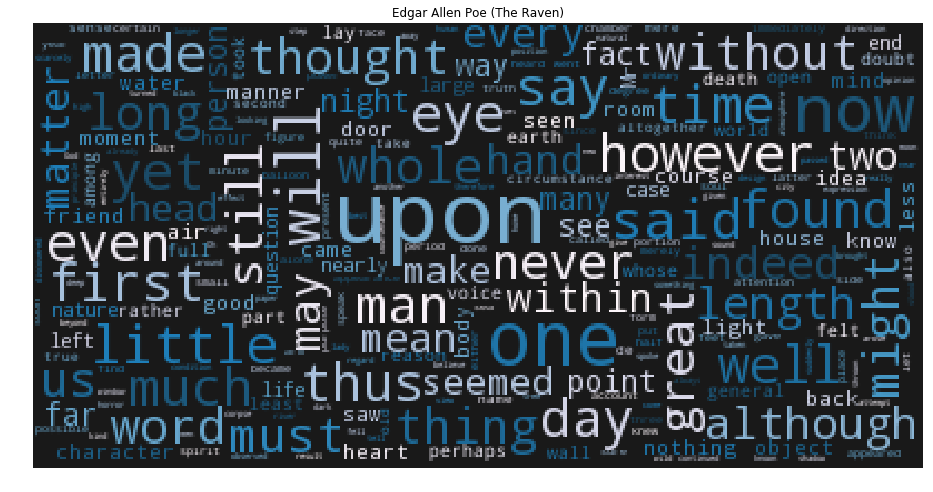

In [10]:
plt.figure(figsize=(20,18))
# The wordcloud of the raven for Edgar Allen Poe
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

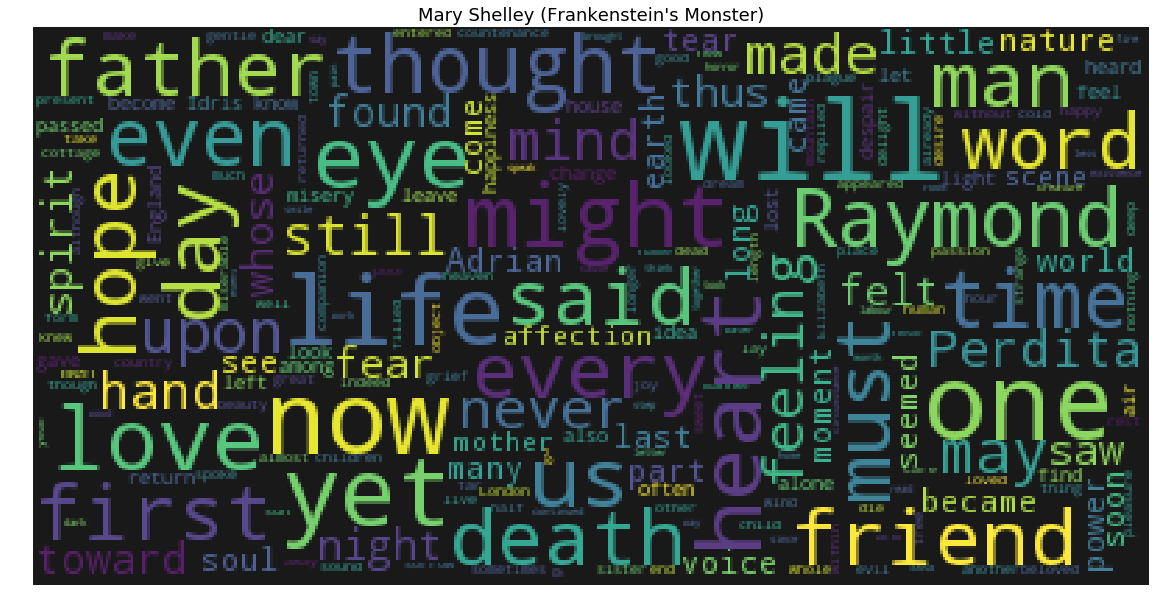

In [11]:
plt.figure(figsize=(20,18))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

# 自然语言处理

In [12]:
# tokenization(分词)
# stopword removal(高频词去除)
first_text = train.text.values[0]
first_text_list = nltk.word_tokenize(first_text)
stopwords = nltk.corpus.stopwords.words('english')
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
first_text_list

['This',
 'process',
 ',',
 'however',
 ',',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the',
 'dimensions',
 'of',
 'my',
 'dungeon',
 ';',
 'as',
 'I',
 'might',
 'make',
 'its',
 'circuit',
 ',',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'I',
 'set',
 'out',
 ',',
 'without',
 'being',
 'aware',
 'of',
 'the',
 'fact',
 ';',
 'so',
 'perfectly',
 'uniform',
 'seemed',
 'the',
 'wall',
 '.']

In [13]:
# stemming and lemmatization(词干提取)
stemmer = nltk.stem.PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [14]:
# vectorizer(向量化，为了机器可读)

In [15]:
# bag_words
all_words = set(train['text'].str.split(expand=True).unstack())

def wordandindex(vocab):
    return {word: i + 3 for i, word in enumerate(vocab)}, {i + 3: word for i, word in enumerate(vocab)}

word2index, index2word = wordandindex(all_words)

In [16]:
label_encoder = LabelEncoder()
# 数据集准备
X = np.array(train.text.apply(lambda sen: [word2index[word] for word in sen.split(' ')]))
y = np.array(label_encoder.fit_transform(train.author))
assert len(X) == len(y)
print(len(all_words))
print(len(train))
print("test length: {}".format(len(test)))
# 句子填充
X_pad = np.zeros((19579, 861))

for i in range(X_pad.shape[0]):
    for j in range(len(X[i])):
        X_pad[i, j] = X[i][j]

xtrain, xvalid, ytrain, yvalid = train_test_split(
    X_pad, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, 
    shuffle=True
)
print("train length: {}".format(len(xtrain)))
#print(xtrain.type)
print("valid length: {}".format(len(xvalid)))
#print(xvalid.type)

47557
19579
test length: 8392
train length: 17621
valid length: 1958


In [17]:
# 最长句子长度设置为 input_size
max = 0
for i, x in enumerate(X):
    # print(len(x))
    if len(x) > max:
        max = len(x)
        
print(max)
# train.iloc[9215].values

# 参数
input_size = 861
num_classes = 3
epochs = 5
lr = 1e-4

861


# 逻辑回归并不是很好

In [ ]:
# 逻辑回归
class LR(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LR, self).__init__()
        self.linear_0 = nn.Linear(input_size, 8192)
        self.linear_1 = nn.Linear(8192, 4096)
        self.linear_2 = nn.Linear(4096, 2048)
        self.linear_3 = nn.Linear(2048, 512)
        self.linear_4 = nn.Linear(512, 128)
        self.linear_5 = nn.Linear(128, 64)
        self.linear_6 = nn.Linear(64, 32)
        self.linear_7 = nn.Linear(32, num_classes)
        
    
    def forward(self, x):
        L1_out = F.elu(self.linear_0(x))
        L2_out = F.elu(self.linear_1(L1_out))
        L3_out = F.elu(self.linear_2(L2_out))
        L4_out = F.elu(self.linear_3(L3_out))
        L5_out = F.elu(self.linear_4(L4_out))
        L6_out = F.elu(self.linear_5(L5_out))
        L7_out = F.elu(self.linear_6(L6_out))
        
        
        final_out = F.log_softmax(self.linear_7(L7_out), dim=1)
        logits = F.softmax(self.linear_7(L7_out), dim=1)
        
        return final_out, logits
    
model = LR(input_size, num_classes).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [19]:
-

16.527721405029297
1.2493932247161865
1.098459243774414
1.0943522453308105
1.096152663230896
1.0953112840652466
1.0953054428100586
1.095352053642273
1.0953458547592163
1.0953526496887207
1.0953572988510132
1.095362663269043
1.095367670059204
1.0953730344772339
1.0953785181045532
1.095384120941162
1.0953900814056396
1.0953959226608276


KeyboardInterrupt: 

In [20]:
N = len(train_acc)
print(N)
random_x = np.linspace(0, 1, N)
random_y0 = np.array(train_acc)
random_y1 = np.array(valid_acc)

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'lines',
    name = 'train_acc'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines',
    name = 'valid_acc'
)

data = [trace0, trace1]

py.iplot(data, filename='line-mode')

100


In [21]:
def test_deal(x):
    sen_vec = []
    for word in x.split(' '):
        if word not in all_words:
            sen_vec.append(2)
        else:
            sen_vec.append(word2index[word])
            
    return sen_vec
            
X_t = np.array(test.text.apply(test_deal))

X_t_pad = np.zeros((8392, 861))

for i in range(X_t_pad.shape[0]):
    for j in range(len(X_t[i])):
        X_t_pad[i, j] = X_t[i][j]

In [22]:
tt = Variable(torch.FloatTensor(X_t_pad)).cuda()
_, res = model(tt)
res

Variable containing:
 0.4085  0.2865  0.3050
 0.4085  0.2865  0.3050
 0.4085  0.2865  0.3050
           ⋮            
 0.4085  0.2865  0.3050
 0.4085  0.2865  0.3050
 0.4085  0.2865  0.3050
[torch.cuda.FloatTensor of size 8392x3 (GPU 0)]

In [23]:
rr = pd.DataFrame(np.array(res.data), columns=['EAP', 'HPL', 'MWS'], index=test.id)

In [24]:
rr.head()

,EAP,HPL,MWS
id,,,
id02310,0.408521,0.286459,0.30502
id24541,0.408521,0.286459,0.30502
id00134,0.408521,0.286459,0.30502
id27757,0.408521,0.286459,0.30502
id04081,0.408521,0.286459,0.30502


In [25]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [26]:
rr.to_csv('222.csv')

# 深度学习技术

### Hierarchical Attention Networks for Document Classification

In [18]:
# Functions to accomplish attention
def batch_matmul_bias(seq, weight, bias):
    s = None
    bias_dim = bias.size()
    for i in range(seq.size(0)):
        _s = torch.mm(seq[i], weight) 
        _s_bias = _s + bias.expand(bias_dim[0], _s.size()[0]).transpose(0,1)
        _s_bias = torch.tanh(_s_bias)
        _s_bias = _s_bias.unsqueeze(0)
        if(s is None):
            s = _s_bias
        else:
            s = torch.cat((s,_s_bias),0)
    return s

def batch_matmul(seq, weight):
    s = None
    for i in range(seq.size(0)):
        _s = torch.mm(seq[i], weight)
        _s = _s.unsqueeze(0)
        if(s is None):
            s = _s
        else:
            s = torch.cat((s,_s),0)
    return s.squeeze()

def attention_mul(rnn_outputs, att_weights):
    attn_vectors = None
    for i in range(rnn_outputs.size(0)):
        h_i = rnn_outputs[i]
        a_i = att_weights[i].unsqueeze(1).expand_as(h_i)
        h_i = a_i * h_i
        h_i = h_i.unsqueeze(0)
        if(attn_vectors is None):
            attn_vectors = h_i
        else:
            attn_vectors = torch.cat((attn_vectors,h_i),0)
    return torch.sum(attn_vectors, 0)

In [19]:
# Hierarchical Attention Networks for Document Classification
class AttentionWordRNN(nn.Module):
    def __init__(self, batch_size, num_tokens, embed_size, word_gru_hidden, n_classes):
        super(AttentionWordRNN, self).__init__()
        
        self.num_tokens = num_tokens
        self.embed_size = embed_size
        self.word_gru_hidden = word_gru_hidden
        self.batch_size = batch_size
        
        # (N, W) => (N, W, embed_size)
        self.lookup = nn.Embedding(num_tokens, embed_size)
        # (seq_len, batch, input_size) + (num_layers * num_directions, batch, hidden_size)
        # => (seq_len, batch, hidden_size * num_directions) + (num_layers * num_directions, batch, hidden_size)
        self.word_gru = nn.GRU(embed_size, word_gru_hidden, 2, bidirectional= True)
        self.softmax_word = nn.Softmax(dim=1)
        self.final_softmax = nn.LogSoftmax(dim=1)
        # ???
        self.final_linear = nn.Linear(2*word_gru_hidden, n_classes)
        
        self.weight_W_word = nn.Parameter(torch.Tensor(2*word_gru_hidden, 2*word_gru_hidden))
        self.bias_word = nn.Parameter(torch.Tensor(2*word_gru_hidden,1))
        self.weight_proj_word = nn.Parameter(torch.Tensor(2*word_gru_hidden, 1))
        
        self.weight_W_word.data.uniform_(-0.1, 0.1)
        self.weight_proj_word.data.uniform_(-0.1,0.1)
    
    def forward(self, x, state_word):
        # embeddings
        embedded = self.lookup(x)
        embedded_resize = embedded.view(-1, self.batch_size, self.embed_size)
        # word level gru
        output_word, state_word = self.word_gru(embedded_resize, state_word)
        # print(output_word.size())
        word_hidden = batch_matmul_bias(output_word, self.weight_W_word, self.bias_word)
        # print(word_hidden.size())
        word_similarity = batch_matmul(word_hidden, self.weight_proj_word)
        # print(word_similarity.size())
        word_weights = self.softmax_word(word_similarity.transpose(1, 0))
        # print(word_weights)
        sen_vector = attention_mul(output_word, word_weights.transpose(1, 0))
        # print(sen_vector)
        final_linear = self.final_linear(sen_vector)
        out = self.final_softmax(final_linear)
        
        return F.softmax(final_linear, dim=1), out, state_word
    
    def init_hidden(self):
        return Variable(torch.zeros(4, self.batch_size, self.word_gru_hidden)).cuda()

In [20]:
# 训练
model = AttentionWordRNN(16, 47560, 256, 128, 3)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [21]:
model.cuda()

AttentionWordRNN(
  (lookup): Embedding(47560, 256)
  (word_gru): GRU(256, 128, num_layers=2, bidirectional=True)
  (softmax_word): Softmax()
  (final_softmax): LogSoftmax()
  (final_linear): Linear(in_features=256, out_features=3)
)

In [22]:
xtrain.astype(int)

array([[31327, 45843, 22025, ...,     0,     0,     0],
       [ 7329, 40733, 15792, ...,     0,     0,     0],
       [21050, 23202,  7237, ...,     0,     0,     0],
       ..., 
       [21050,   190, 42257, ...,     0,     0,     0],
       [25259, 34846, 40639, ...,     0,     0,     0],
       [11106,   111, 17711, ...,     0,     0,     0]])

In [23]:
epochs = 1
# 训练模型
for epoch in range(epochs):
    vx = Variable(torch.LongTensor(xtrain.astype(int))).cuda()
    vy = Variable(torch.LongTensor(ytrain)).cuda()
    optimizer.zero_grad()
    for i in range(0, len(xtrain), 16):
        if i + 16 > len(xtrain):
            vx_batch = vx[-17:-1]
            vy_batch = vy[-17:-1]
        else:
            vx_batch = vx[i:i+16]
            vy_batch = vy[i:i+16]
            
        print(vx_batch.size())
        hidden = model.init_hidden()
        results, outputs, _ = model(vx_batch, hidden)
        loss = criterion(outputs, vy_batch)
        loss.backward()
        optimizer.step()
        
        _, res = results.data.max(1)
        print(loss.data[0])
        print((torch.sum(res == vy_batch.data) + 0.0) / 16.0)

torch.Size([16, 861])
1.0899690389633179
0.5
torch.Size([16, 861])
0.9757173657417297
0.6875
torch.Size([16, 861])
1.1253715753555298
0.375
torch.Size([16, 861])
1.1425747871398926
0.375
torch.Size([16, 861])
1.2548977136611938
0.3125
torch.Size([16, 861])
1.5428409576416016
0.1875
torch.Size([16, 861])
1.4730647802352905
0.125
torch.Size([16, 861])
1.24491286277771
0.3125
torch.Size([16, 861])
1.0971473455429077
0.4375
torch.Size([16, 861])
1.1438043117523193
0.5
torch.Size([16, 861])
1.175447940826416
0.3125
torch.Size([16, 861])
1.28268563747406
0.25
torch.Size([16, 861])
1.2274141311645508
0.125
torch.Size([16, 861])
1.0750712156295776
0.4375
torch.Size([16, 861])
1.02499258518219
0.5625
torch.Size([16, 861])
1.0788127183914185
0.4375
torch.Size([16, 861])
1.2539087533950806
0.0625
torch.Size([16, 861])
1.4536330699920654
0.125
torch.Size([16, 861])
1.0500493049621582
0.5
torch.Size([16, 861])
1.0505774021148682
0.5
torch.Size([16, 861])
1.3388344049453735
0.25
torch.Size([16, 861]

1.0934070348739624
0.4375
torch.Size([16, 861])
1.0934308767318726
0.4375
torch.Size([16, 861])
1.0707865953445435
0.5
torch.Size([16, 861])
1.0860860347747803
0.4375
torch.Size([16, 861])
1.162839412689209
0.4375
torch.Size([16, 861])
1.202367901802063
0.25
torch.Size([16, 861])
1.1191939115524292
0.5625
torch.Size([16, 861])
1.031045913696289
0.5
torch.Size([16, 861])
1.0965670347213745
0.3125
torch.Size([16, 861])
1.1964048147201538
0.3125
torch.Size([16, 861])
1.084797739982605
0.5625
torch.Size([16, 861])
1.1597633361816406
0.375
torch.Size([16, 861])
1.0337387323379517
0.5
torch.Size([16, 861])
1.2917823791503906
0.25
torch.Size([16, 861])
1.016253113746643
0.5
torch.Size([16, 861])
1.3017102479934692
0.25
torch.Size([16, 861])
1.1343318223953247
0.4375
torch.Size([16, 861])
1.2959182262420654
0.5
torch.Size([16, 861])
1.0672736167907715
0.5
torch.Size([16, 861])
1.2206778526306152
0.25
torch.Size([16, 861])
1.246482491493225
0.375
torch.Size([16, 861])
1.219807744026184
0.4375
t

0.9850949048995972
0.5625
torch.Size([16, 861])
1.2720880508422852
0.3125
torch.Size([16, 861])
1.1662275791168213
0.4375
torch.Size([16, 861])
1.078726053237915
0.5
torch.Size([16, 861])
1.1774479150772095
0.4375
torch.Size([16, 861])
1.1160420179367065
0.5
torch.Size([16, 861])
1.1160483360290527
0.4375
torch.Size([16, 861])
0.8273561596870422
0.6875
torch.Size([16, 861])
1.2857450246810913
0.375
torch.Size([16, 861])
1.1397727727890015
0.4375
torch.Size([16, 861])
1.5247300863265991
0.1875
torch.Size([16, 861])
1.4633874893188477
0.1875
torch.Size([16, 861])
1.2507158517837524
0.375
torch.Size([16, 861])
1.1319553852081299
0.4375
torch.Size([16, 861])
0.9088605046272278
0.625
torch.Size([16, 861])
1.2542155981063843
0.375
torch.Size([16, 861])
1.1773370504379272
0.375
torch.Size([16, 861])
1.431747555732727
0.1875
torch.Size([16, 861])
1.3720699548721313
0.25
torch.Size([16, 861])
0.9788793921470642
0.5625
torch.Size([16, 861])
1.0445408821105957
0.5
torch.Size([16, 861])
1.17635273

1.2288802862167358
0.3125
torch.Size([16, 861])
1.2289364337921143
0.375
torch.Size([16, 861])
1.225632667541504
0.1875
torch.Size([16, 861])
1.0831001996994019
0.5
torch.Size([16, 861])
1.1351319551467896
0.4375
torch.Size([16, 861])
1.1977887153625488
0.375
torch.Size([16, 861])
1.1656908988952637
0.5
torch.Size([16, 861])
1.1543350219726562
0.375
torch.Size([16, 861])
1.337512493133545
0.25
torch.Size([16, 861])
1.342159628868103
0.3125
torch.Size([16, 861])
1.381571888923645
0.1875
torch.Size([16, 861])
1.3117238283157349
0.25
torch.Size([16, 861])
1.317236304283142
0.25
torch.Size([16, 861])
1.2817070484161377
0.3125
torch.Size([16, 861])
1.0260416269302368
0.5
torch.Size([16, 861])
1.3524935245513916
0.3125
torch.Size([16, 861])
1.2144243717193604
0.375
torch.Size([16, 861])
1.0891495943069458
0.4375
torch.Size([16, 861])
1.4577207565307617
0.1875
torch.Size([16, 861])
1.4369299411773682
0.25
torch.Size([16, 861])
1.162385106086731
0.4375
torch.Size([16, 861])
1.4570033550262451


1.2639598846435547
0.3125
torch.Size([16, 861])
1.2922546863555908
0.375
torch.Size([16, 861])
1.208979606628418
0.375
torch.Size([16, 861])
1.2507944107055664
0.375
torch.Size([16, 861])
1.2089482545852661
0.375
torch.Size([16, 861])
1.3738709688186646
0.25
torch.Size([16, 861])
1.4707878828048706
0.25
torch.Size([16, 861])
1.4693201780319214
0.375
torch.Size([16, 861])
1.7648869752883911
0.1875
torch.Size([16, 861])
1.233863115310669
0.5625
torch.Size([16, 861])
1.4153941869735718
0.375
torch.Size([16, 861])
1.6545802354812622
0.1875
torch.Size([16, 861])
1.551682472229004
0.3125
torch.Size([16, 861])
1.2956801652908325
0.375
torch.Size([16, 861])
1.41721773147583
0.25
torch.Size([16, 861])
1.547214388847351
0.25
torch.Size([16, 861])
1.5208569765090942
0.375
torch.Size([16, 861])
1.4165900945663452
0.3125
torch.Size([16, 861])
1.6761215925216675
0.25
torch.Size([16, 861])
1.3972736597061157
0.1875
torch.Size([16, 861])
0.9817068576812744
0.6875
torch.Size([16, 861])
1.63806712627410

1.1615811586380005
0.1875
torch.Size([16, 861])
1.1412272453308105
0.3125
torch.Size([16, 861])
1.0123491287231445
0.5625
torch.Size([16, 861])
1.023390531539917
0.5625
torch.Size([16, 861])
1.1634202003479004
0.4375
torch.Size([16, 861])
1.1176098585128784
0.25
torch.Size([16, 861])
1.1079515218734741
0.375
torch.Size([16, 861])
1.045748233795166
0.4375
torch.Size([16, 861])
1.149949312210083
0.3125
torch.Size([16, 861])
1.16526198387146
0.3125
torch.Size([16, 861])
1.0626294612884521
0.5
torch.Size([16, 861])
1.2405790090560913
0.1875
torch.Size([16, 861])
1.1687164306640625
0.3125
torch.Size([16, 861])
1.0964603424072266
0.3125
torch.Size([16, 861])
1.1713910102844238
0.375
torch.Size([16, 861])
1.0230014324188232
0.375
torch.Size([16, 861])
1.396765112876892
0.25
torch.Size([16, 861])
1.2172189950942993
0.375
torch.Size([16, 861])
1.246158480644226
0.375
torch.Size([16, 861])
1.2275872230529785
0.375
torch.Size([16, 861])
1.2639143466949463
0.3125
torch.Size([16, 861])
1.5952955484

1.4812591075897217
0.25
torch.Size([16, 861])
1.2985152006149292
0.3125
torch.Size([16, 861])
1.239875078201294
0.3125
torch.Size([16, 861])
1.2373991012573242
0.4375
torch.Size([16, 861])
1.4777090549468994
0.1875
torch.Size([16, 861])
1.3506771326065063
0.3125
torch.Size([16, 861])
1.1790046691894531
0.4375
torch.Size([16, 861])
1.3725403547286987
0.125
torch.Size([16, 861])
1.3230910301208496
0.1875
torch.Size([16, 861])
1.252947449684143
0.375
torch.Size([16, 861])
1.2176427841186523
0.375
torch.Size([16, 861])
0.9615729451179504
0.5
torch.Size([16, 861])
1.3585792779922485
0.25
torch.Size([16, 861])
1.254621148109436
0.1875
torch.Size([16, 861])
1.2390369176864624
0.25
torch.Size([16, 861])
1.4196364879608154
0.0625
torch.Size([16, 861])
1.1974824666976929
0.3125
torch.Size([16, 861])
0.8848196268081665
0.625
torch.Size([16, 861])
1.1736429929733276
0.375
torch.Size([16, 861])
1.18408203125
0.25
torch.Size([16, 861])
1.1473290920257568
0.3125
torch.Size([16, 861])
1.19989097118377

In [24]:
def test_deal(x):
    sen_vec = []
    for word in x.split(' '):
        if word not in all_words:
            sen_vec.append(2)
        else:
            sen_vec.append(word2index[word])
            
    return sen_vec
            
X_t = np.array(test.text.apply(test_deal))

X_t_pad = np.zeros((8392, 861))

for i in range(X_t_pad.shape[0]):
    for j in range(len(X_t[i])):
        X_t_pad[i, j] = X_t[i][j]

In [31]:
hidden = model.init_hidden()
tt = Variable(torch.LongTensor(X_t_pad.astype(int)))
tt

Variable containing:
 32217   2251  44862  ...       0      0      0
 17546   4130   7487  ...       0      0      0
 45090  40752   7658  ...       0      0      0
        ...            ⋱           ...         
  8225  25211  11873  ...       0      0      0
  3468  29801   2251  ...       0      0      0
 30546      2      2  ...       0      0      0
[torch.LongTensor of size 8392x861]

In [34]:
model.parameters()

<generator object Module.parameters at 0x7f37940318e0>

In [32]:
for i in range(0, len(xtrain), 16):
        vx_batch = tt[i:i+16]
        
        hidden = model.init_hidden()
        results, outputs, _ = model(vx_batch, hidden)
        
        print(results)

TypeError: torch.index_select received an invalid combination of arguments - got ([32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.LongTensor[0m), but expected (torch.cuda.FloatTensor source, int dim, torch.cuda.LongTensor index)

In [25]:
for epoch in range(epochs):
    results = np.array([])
    vx = Variable(torch.LongTensor(X_t_pad.astype(int)))
    for i in range(0, len(X_t_pad), 10):
        vx_batch = vx[i:i+10]
        print(vx_batch.size())    
        result, _, _ = model(vx_batch, hidden)

NameError: name 'X_t_pad' is not defined

In [331]:
model = AttentionWordRNN(2, 100, 20, 20, 3)

In [319]:
x = Variable(torch.floor(torch.rand(2, 10)*9).type(torch.LongTensor))
print(x.type)
init = model.init_hidden()
model(x, init)

<bound method Variable.type of Variable containing:
    5     6     3     2     8     8     8     6     8     7
    3     3     0     1     3     7     8     7     4     4
[torch.LongTensor of size 2x10]
>
torch.Size([10, 2, 20])
torch.Size([10, 2, 20])
torch.Size([10, 2])
Variable containing:
 0.1000  0.1006  0.0997  0.0996  0.0997  0.1001  0.0999  0.1002  0.0997  0.1004
 0.1001  0.1004  0.0996  0.1006  0.1000  0.1002  0.1000  0.0998  0.0995  0.1000
[torch.FloatTensor of size 2x10]

Variable containing:

Columns 0 to 9 
-0.1655 -0.1371 -0.3258  0.2220  0.4530 -0.0975 -0.0319 -0.3808  0.0944 -0.0863
-0.1737 -0.1951 -0.2044 -0.0779  0.3007 -0.1324 -0.3761 -0.2312 -0.1111  0.3872

Columns 10 to 19 
 0.0601 -0.1766  0.0742  0.0062  0.2991 -0.4741 -0.1618  0.2633  0.0062 -0.1212
 0.0957  0.0062  0.3009 -0.0646  0.1192 -0.1222 -0.1604 -0.1235  0.0424 -0.2502
[torch.FloatTensor of size 2x20]



Variable containing:
 0.2818  0.3178  0.4004
 0.3048  0.3614  0.3337
[torch.FloatTensor of size 2x3]

In [320]:
s = torch.rand(9, 3, 5)
w = torch.rand(5, 5)
w1 = torch.rand(5, 1)
b = torch.rand(5, 1)
ss = batch_matmul_bias(s, w, b)

In [321]:
ss.size()

torch.Size([9, 3, 5])

In [322]:
s = torch.rand(1, 4, 5)
s2 = torch.rand(1, 4, 5)
sss = torch.cat((s, s2), 0)

In [323]:
sss.size()

torch.Size([2, 4, 5])

In [324]:
s = torch.rand(9, 3, 5)
w = torch.rand(5, 5)
w1 = torch.rand(5, 1)
b = torch.rand(5, 1)

In [325]:
a = F.softmax(batch_matmul(s, w1))
a[0]

Variable containing:
 0.3583
 0.3090
 0.3327
[torch.FloatTensor of size 3]

In [326]:
a[0].unsqueeze(1).expand_as(torch.rand(3, 5))

Variable containing:
 0.3583  0.3583  0.3583  0.3583  0.3583
 0.3090  0.3090  0.3090  0.3090  0.3090
 0.3327  0.3327  0.3327  0.3327  0.3327
[torch.FloatTensor of size 3x5]

In [327]:
a = torch.rand(9, 3, 5)
b = torch.sum(a, 0)
b.size()

torch.Size([3, 5])

In [328]:
torch.ceil(torch.rand(2, 10)*100)


   33    76    72    48     1     3    53    23    85    84
   88    88    47    61    26    47    93    14    75    41
[torch.FloatTensor of size 2x10]

In [329]:
np.array(torch.rand(2, 10)*100)

array(

Columns 0 to 7 
 79.3451  19.7294   3.6730  95.8092  60.5555   6.8698  98.6816   1.7559
  8.2315  81.9254  11.2149  37.8706  85.5708   9.9544  37.8996  15.4472

Columns 8 to 9 
 18.4864  89.4557
 21.0955   0.5120
[torch.FloatTensor of size 2x10]
, dtype=object)

In [28]:
a = Variable(torch.rand(2,3))
b = F.softmax(a,dim=1)
b

Variable containing:
 0.1968  0.3908  0.4124
 0.1951  0.4129  0.3920
[torch.FloatTensor of size 2x3]